In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cex = pd.read_pickle("/content/drive/MyDrive/TU/cex_ETH_USDT_2022.pkl")
dex = pd.read_pickle("/content/drive/MyDrive/TU/dex_WETH_USDT_2022.pkl")

In [3]:
# Filtering and merging price data
merged = cex.merge(dex, left_index=True, right_index=True, suffixes=('_cex', '_dex'))
df_filt = merged[['close_cex', 'close_dex']].dropna(subset=['close_cex', 'close_dex'])
df = df_filt.rename(columns={'close_cex': 'cex_price', 'close_dex': 'dex_price'})

# Normalize the price data
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[['cex_price', 'dex_price']]), columns=['cex_price', 'dex_price'], index=df.index)


In [4]:
df_norm


,cex_price,dex_price
2022-01-01 00:00:00,0.932023,0.928835
2022-01-01 00:01:00,0.934258,0.933218
2022-01-01 00:02:00,0.934947,0.932821
2022-01-01 00:03:00,0.933935,0.932821
2022-01-01 00:04:00,0.933772,0.932647
...,...,...
2022-12-31 23:54:00,0.103359,0.103857
2022-12-31 23:55:00,0.103309,0.103864
2022-12-31 23:56:00,0.103332,0.103864
2022-12-31 23:57:00,0.103132,0.103677


In [5]:
def cross_correlation(series1, series2, max_lag):
    correlation_values = []
    lag_values = []

    for lag in range(-max_lag, max_lag + 1):
        shifted_series2 = np.roll(series2, lag)
        valid_indices = abs(lag)

        correlation = np.corrcoef(series1[valid_indices:], shifted_series2[valid_indices:])[0, 1]
        correlation_values.append(correlation)
        lag_values.append(lag)

    max_correlation_index = np.argmax(correlation_values)
    max_correlation = correlation_values[max_correlation_index]
    lag = lag_values[max_correlation_index]

    return lag, max_correlation


In [6]:
def plot_cross_correlation(lag_values, correlation_values):
    plt.stem(lag_values, correlation_values)
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title('Cross Correlation Plot')
    plt.show()


In [7]:
def test_cross_correlation_with_window(series1, series2, window_size, step_size):
    num_windows = (len(series1) - window_size) // step_size + 1
    correlation_values = []
    lag_values = []

    for i in range(num_windows):
        start_index = i * step_size
        end_index = start_index + window_size
        window_series1 = series1[start_index:end_index]
        window_series2 = series2[start_index:end_index]
        lag, correlation = cross_correlation(window_series1, window_series2, max_lag=30)

        correlation_values.append(correlation)
        lag_values.append(lag)

    return lag_values, correlation_values


In [8]:
window_lags, window_correlations = test_cross_correlation_with_window(df_norm.dex_price, df_norm.cex_price, window_size=500, step_size=200)

In [9]:
print(window_lags)

[1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

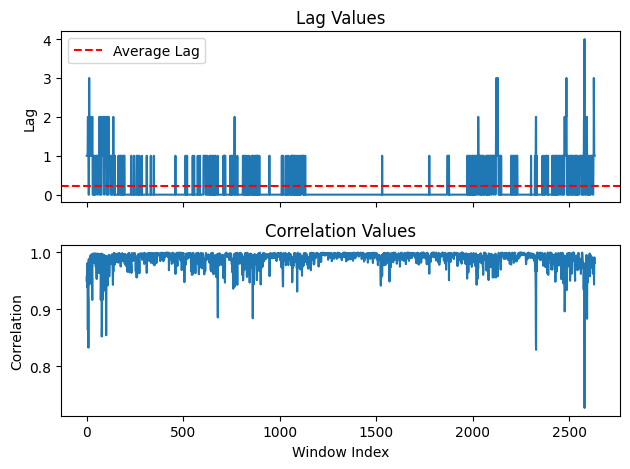

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot lags
ax1.plot(range(len(window_lags)), window_lags)
ax1.axhline(y=sum(window_lags) / len(window_lags), color='red', linestyle='--', label='Average Lag')
ax1.set_ylabel('Lag')
ax1.set_title('Lag Values')
ax1.legend()

# Plot correlations
ax2.plot(range(len(window_correlations)), window_correlations)
ax2.set_xlabel('Window Index')
ax2.set_ylabel('Correlation')
ax2.set_title('Correlation Values')

plt.tight_layout()
plt.savefig('cross_correlation_eth_plot.png', dpi=300)
plt.show()

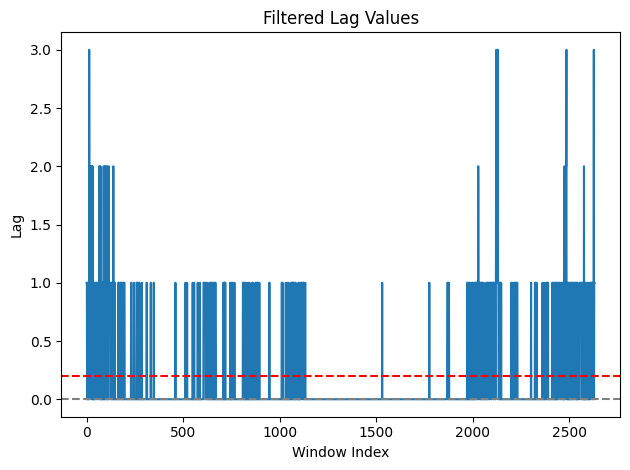

In [11]:
fig, ax = plt.subplots()

# Filter lag values based on correlation threshold
filtered_lags = [lag if correlation >= .95 else 0 for lag, correlation in zip(window_lags, window_correlations)]

# Plot filtered lag values
ax.plot(range(len(filtered_lags)), filtered_lags)
ax.axhline(y=sum(filtered_lags) / len(filtered_lags), color='red', linestyle='--', label='Average Lag')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_ylabel('Lag')
ax.set_xlabel('Window Index')
ax.set_title('Filtered Lag Values')

plt.tight_layout()
plt.savefig('cross_correlation_eth_filtered_plot.png', dpi=300)
plt.show()